In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation


In [2]:
data_dir = script_dir / "transformed_data_Cedric"
TRAINING_SAMPLES_FILE = data_dir / "itrainsample.csv"
# TEST_SAMPLES_FILE = data_dir / "itestsample.csv"
TEST_SAMPLES_FILE = TRAINING_SAMPLES_FILE  ## should have zero MAE

## Load & process input data

In [3]:
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
TEST_SAMPLES_FILE = shutil.copy(TEST_SAMPLES_FILE, tmp_folder)

### Filtering

In [4]:
lambda_nerve_within_SCT_lower = (
    lambda x: x["DEPTH"] + x["DIAMETER"] / 2 < x["THICKNESS_SKIN"] + x["THICKNESS_SCT"]
)
lambda_nerve_within_SCT_lower.__name__ = "lambda_nerve_within_SCT_lower"

#

lambda_nerve_within_SCT_upper = (
    lambda x: x["DEPTH"] - x["DIAMETER"] / 2 > x["THICKNESS_SKIN"]
)
lambda_nerve_within_SCT_upper.__name__ = "lambda_nerve_within_SCT_upper"

#

lambda_nerve_within_SCT_lower_mild = (
    lambda x: x["DEPTH"] < x["THICKNESS_SKIN"] + x["THICKNESS_SCT"]
)
lambda_nerve_within_SCT_lower_mild.__name__ = "lambda_nerve_within_SCT_lower_mild"

#

lambda_nerve_within_SCT_upper_mild = lambda x: x["DEPTH"] > x["THICKNESS_SKIN"]
lambda_nerve_within_SCT_upper_mild.__name__ = "lambda_nerve_within_SCT_upper_mild"

#

lambda_electrode_within_LAT = lambda x: x["THICKNESS_LOOSE_AREOLAR_TISSUE"] >= 0.3
lambda_electrode_within_LAT.__name__ = "lambda_electrode_within_LAT"

In [7]:
def apply_lambdas_to_file(file, lambdas):
    data = funs_data_processing.load_data(file)
    if "interface" in data.columns:
        data.drop(columns=["interface"], inplace=True)
    data = data.astype(float)
    for l in lambdas:
        keep = data.apply(l, axis=1)
        print(
            f"Applying lambda: {l.__name__} filtered {100*(1-keep.sum()/len(data)):.2f}% of the data."
        )
    keep = data.apply(lambda x: np.all([l(x) for l in lambdas]), axis=1)
    print(
        f"Joint filtering filtered {100*(1-keep.sum()/len(data)):.2f}% of the data.\n"
    )
    return keep


untransformed_data_dir = script_dir / "original_data"
UNTRANSFORMED_TRAINING_SAMPLES_FILE = untransformed_data_dir / "18D_800LHS.dat"
# UNTRANSFORMED_TEST_SAMPLES_FILE = (
#     untransformed_data_dir / "testDakota_18D_100LHS_json.txt"
# )
UNTRANSFORMED_TEST_SAMPLES_FILE = UNTRANSFORMED_TRAINING_SAMPLES_FILE

keep_training = apply_lambdas_to_file(
    UNTRANSFORMED_TRAINING_SAMPLES_FILE,
    [
        lambda_nerve_within_SCT_lower_mild,
        lambda_nerve_within_SCT_upper_mild,
        lambda_electrode_within_LAT,
    ],
)
keep_test = apply_lambdas_to_file(
    UNTRANSFORMED_TEST_SAMPLES_FILE,
    [
        lambda_nerve_within_SCT_lower_mild,
        lambda_nerve_within_SCT_upper_mild,
        lambda_electrode_within_LAT,
    ],
)

Applying lambda: lambda_nerve_within_SCT_lower_mild filtered 19.00% of the data.
Applying lambda: lambda_nerve_within_SCT_upper_mild filtered 6.13% of the data.
Applying lambda: lambda_electrode_within_LAT filtered 21.38% of the data.
Joint filtering filtered 40.50% of the data.

Applying lambda: lambda_nerve_within_SCT_lower_mild filtered 19.00% of the data.
Applying lambda: lambda_nerve_within_SCT_upper_mild filtered 6.13% of the data.
Applying lambda: lambda_electrode_within_LAT filtered 21.38% of the data.
Joint filtering filtered 40.50% of the data.



In [15]:
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(
    TRAINING_SAMPLES_FILE,
    keep_idxs=keep_training,
    columns_to_remove=["Interface"],
)

# PROCESSED_TEST_FILE = funs_data_processing.process_input_file(
#     TEST_SAMPLES_FILE,
#     keep_idxs=keep_test,
#     columns_to_remove=[
#         "Interface",
#         "AfPeak",
#         "aAfPeak",
#         "res",
#         "ares",
#         "nres",
#         "anres",
#     ],
#     # remove the output column; needs to be evaluated
# )

Keeping only 476 rows (of 800)


In [16]:
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)
# variables_test = funs_data_processing.get_variable_names(PROCESSED_TEST_FILE)
# print(variables_test)

['Id', 'Depth', 'Diameter', 'Angle', 'ThicknessSkin', 'ThicknessSct', 'ThicknessAponeurosis', 'ThicknessLooseAreolarTissue', 'ThicknessSkullOuter', 'ThicknessSkullDiploe', 'ThicknessSkullInner', 'ThicknessCsf', 'ConductivitySkin', 'ConductivitySct', 'ConductivityAponeurosis', 'ConductivityLooseAreolarTissue', 'ConductivitySkullCortical', 'ConductivitySkullDiploe', 'ConductivityCsf', 'AfPeak']


## Plot input data (Fig03 & Fig07)

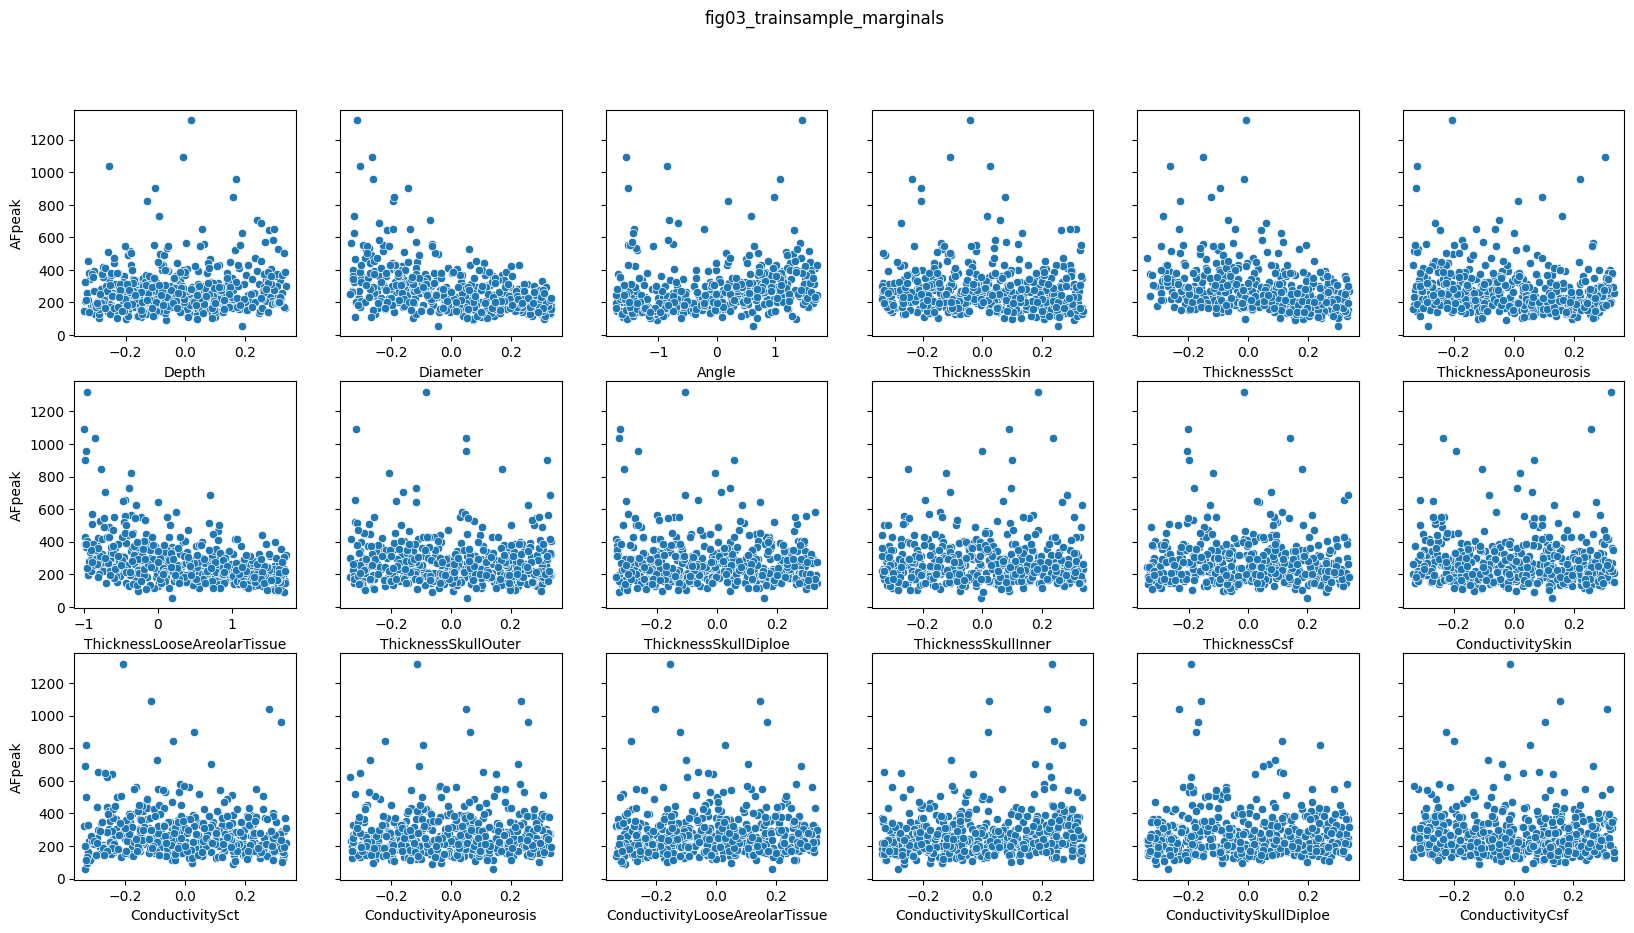

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

title = "fig03_trainsample_marginals"
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
data = funs_data_processing.load_data(PROCESSED_TRAINING_FILE)
data = data.astype(np.float64)
data.rename(columns={"AfPeak": "AFpeak"}, inplace=True)
data.head()
axs: List[plt.Axes] = axs.flatten()
# fig, axs = plt.subplots(1,1, figsize=(15, 15), sharey=True)
# axs = [axs]
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="AFpeak", ax=ax)
    # plt.scatter(data[c].values, data["AFpeak"].values)
    ax.set_xlabel(c)
    # ax.hlines(0.0, data[c].min(), data[c].max(), color="black", linestyle="--")
plt.suptitle(title)
plt.show()

## Create & run Dakota study

In [18]:
dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE,
    cross_validation_folds=10,
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(PROCESSED_TRAINING_FILE)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-1],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-1])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                
                cross_validation folds = 10 
                metrics = "root_mean_squared" "sum_abs" "mean_abs" "max_abs" "rsquared"
                
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/itrainsample_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo responses!!
   

In [19]:
# os.chdir(tmp_folder)
# study = dakenv.study(
#     callbacks={},  ## DONT NEED ANY MODEL EVALUATIONS
#     input_string=dakota_conf,
# )
# study.execute()
# os.chdir(script_dir)

os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

# import subprocess

# subprocess.run(
#     " ".join(["dakota", "-i", str(dakota_conf_path), "-o", "rest.out"]),
#     shell=True,
#     cwd=tmp_folder,
# )

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Wed Sep  4 16:10:36 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 18 variables and 1 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/itrainsample_processed.txt'
Variables read:
                     -2.2670800000e-01 Depth
                      5.2842800000e-02 Diameter
                     -1.7108100000e+00 Angle
                      9.9354500000e-02 ThicknessSkin
                      1.1395700000e-01 ThicknessSct
                      2.0592400000e-01 ThicknessAponeurosis
                      7.3469200000e-01 ThicknessLooseAreolarTissue
                  

## Evaluate Dakota predictions

In [ ]:
y = funs_data_processing.get_results(TEST_SAMPLES_FILE, "AfPeak")
y = y[keep_test]
y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", "AfPeak")
std = np.sqrt(
    funs_data_processing.get_results(tmp_folder / "variances.dat", "AfPeak_variance")
)
y_tilde = (y - y_hat) / std

In [ ]:
np.mean(np.abs(y - y_hat))

np.float64(229.2338689582692)

k =  1.5
The data IS normally distributed. p-value: 0.511588518920929


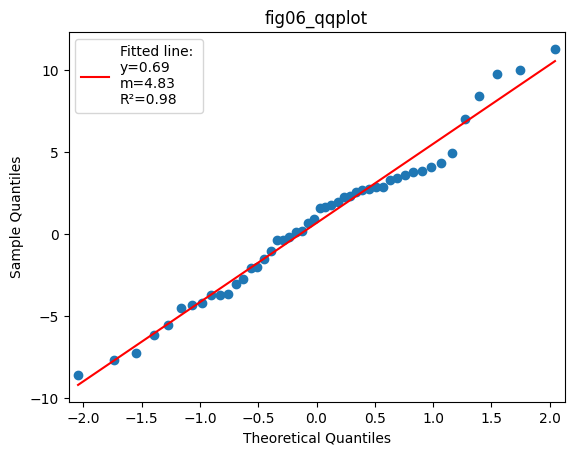

k =  None
The data IS normally distributed. p-value: 0.17623426576443557


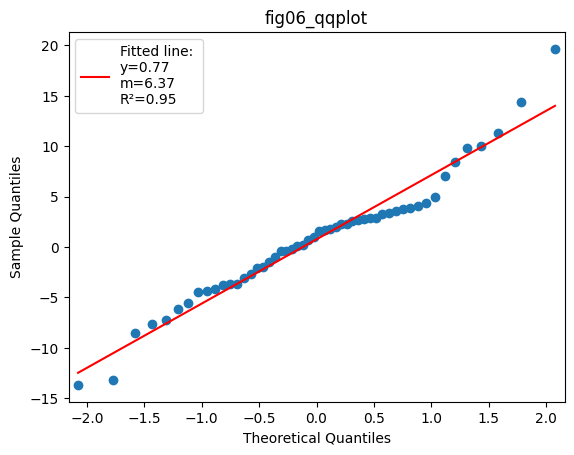

In [ ]:
from utils import funs_gp_evaluation
import matplotlib.pyplot as plt

for k in [1.5, None]:  # outlier detection threshold
    print("k = ", k)
    pval = funs_gp_evaluation.test_normality(y_tilde, k)
    slope, intercept, r2 = funs_gp_evaluation.make_qqplot(y_tilde, k, MAKEPLOT=True)
    plt.title("fig06_qqplot")
    plt.show()

In [ ]:
data = funs_data_processing.load_data(PROCESSED_TEST_FILE)
data = data.astype(np.float64)
data["y"] = y
data["y_hat"] = y_hat
data["res"] = y - y_hat
data["ares"] = np.abs(y - y_hat)
data["nres"] = y_tilde
data["anres"] = np.abs(y_tilde)
data.head()

,Id,Depth,Diameter,Angle,ThicknessSkin,ThicknessSct,ThicknessAponeurosis,ThicknessLooseAreolarTissue,ThicknessSkullOuter,ThicknessSkullDiploe,...,ConductivityLooseAreolarTissue,ConductivitySkullCortical,ConductivitySkullDiploe,ConductivityCsf,y,y_hat,res,ares,nres,anres
0,13.0,-0.024571,-0.146174,-1.075580,0.267458,0.292351,-0.211020,0.255411,0.268426,-0.175189,...,-0.292252,-0.155304,-0.221874,-0.334509,431.203,82.728230,348.474770,348.474770,7.046389,7.046389
1,67.0,-0.278867,0.224001,0.080903,0.134583,0.228502,-0.027280,-0.604918,-0.318000,-0.149221,...,-0.258935,0.145832,0.091882,0.194548,342.421,192.248681,150.172319,150.172319,2.900510,2.900510
2,43.0,-0.089490,-0.124288,-0.321233,-0.319748,0.284498,-0.188482,1.314670,0.104475,-0.079215,...,-0.274266,0.133154,0.260879,0.087484,311.314,105.640658,205.673342,205.673342,4.077483,4.077483
3,66.0,-0.336969,0.091831,-0.286031,-0.017445,0.028495,-0.224060,-0.963812,-0.164423,0.116845,...,0.208596,0.119160,-0.168372,-0.007836,275.387,284.600598,-9.213598,9.213598,-0.184350,0.184350
4,35.0,0.073526,-0.249718,0.989657,-0.085004,-0.195412,0.189730,-0.082981,0.246528,0.319404,...,-0.325007,-0.093531,-0.194203,0.323085,648.491,374.969347,273.521653,273.521653,4.976847,4.976847


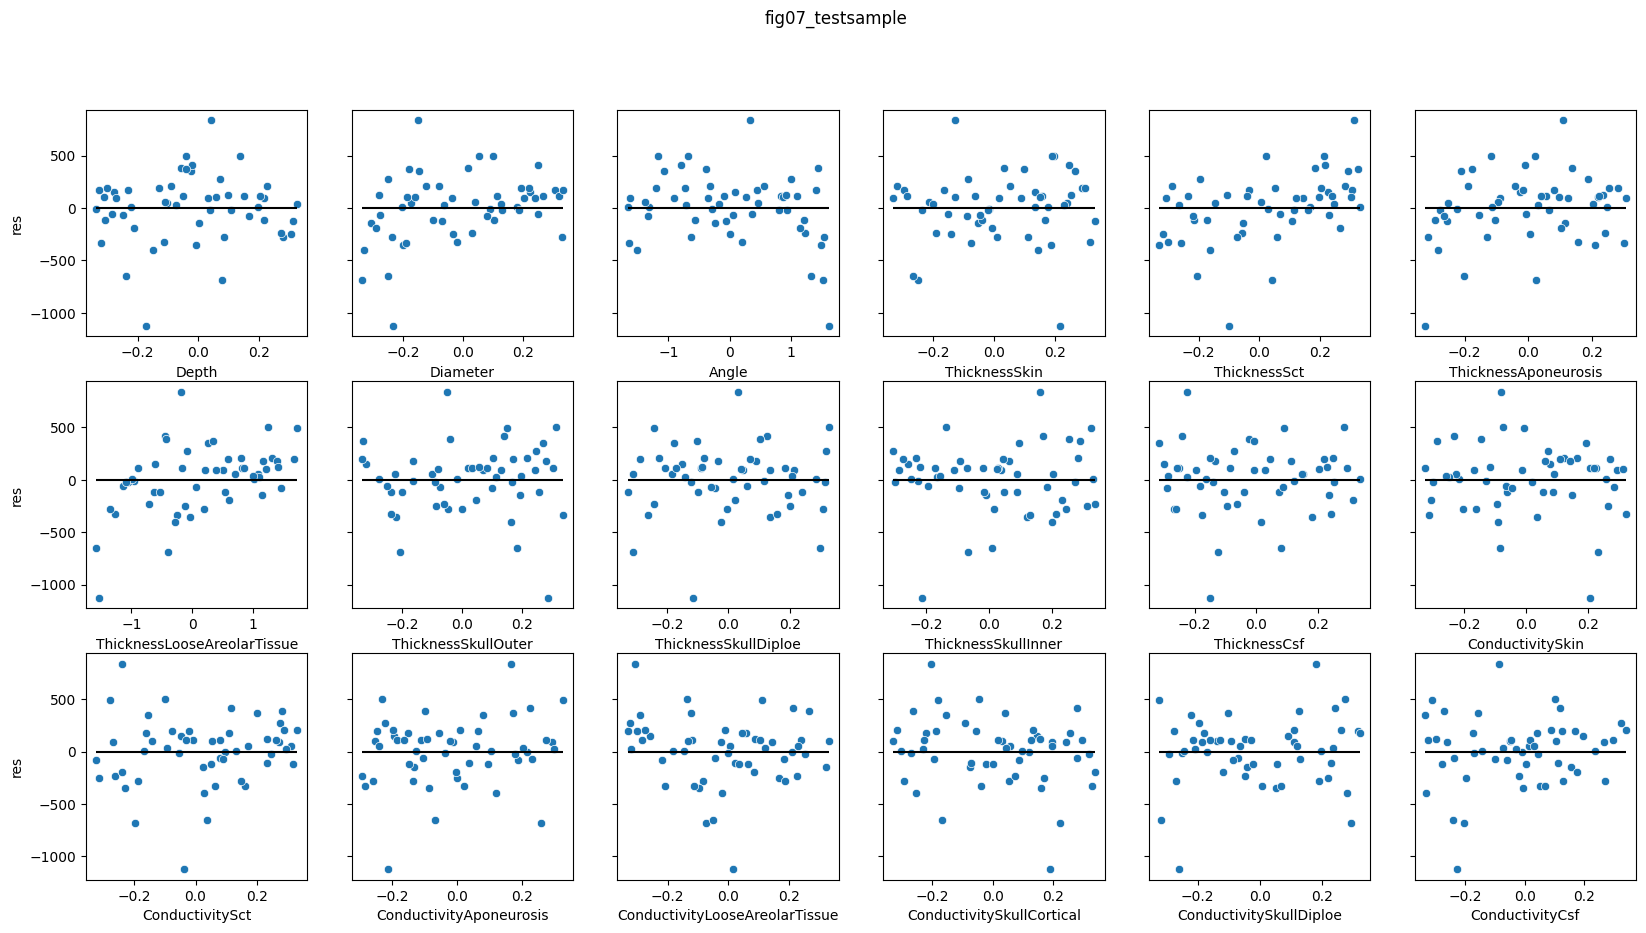

In [ ]:
title = "fig07_testsample"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="res", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

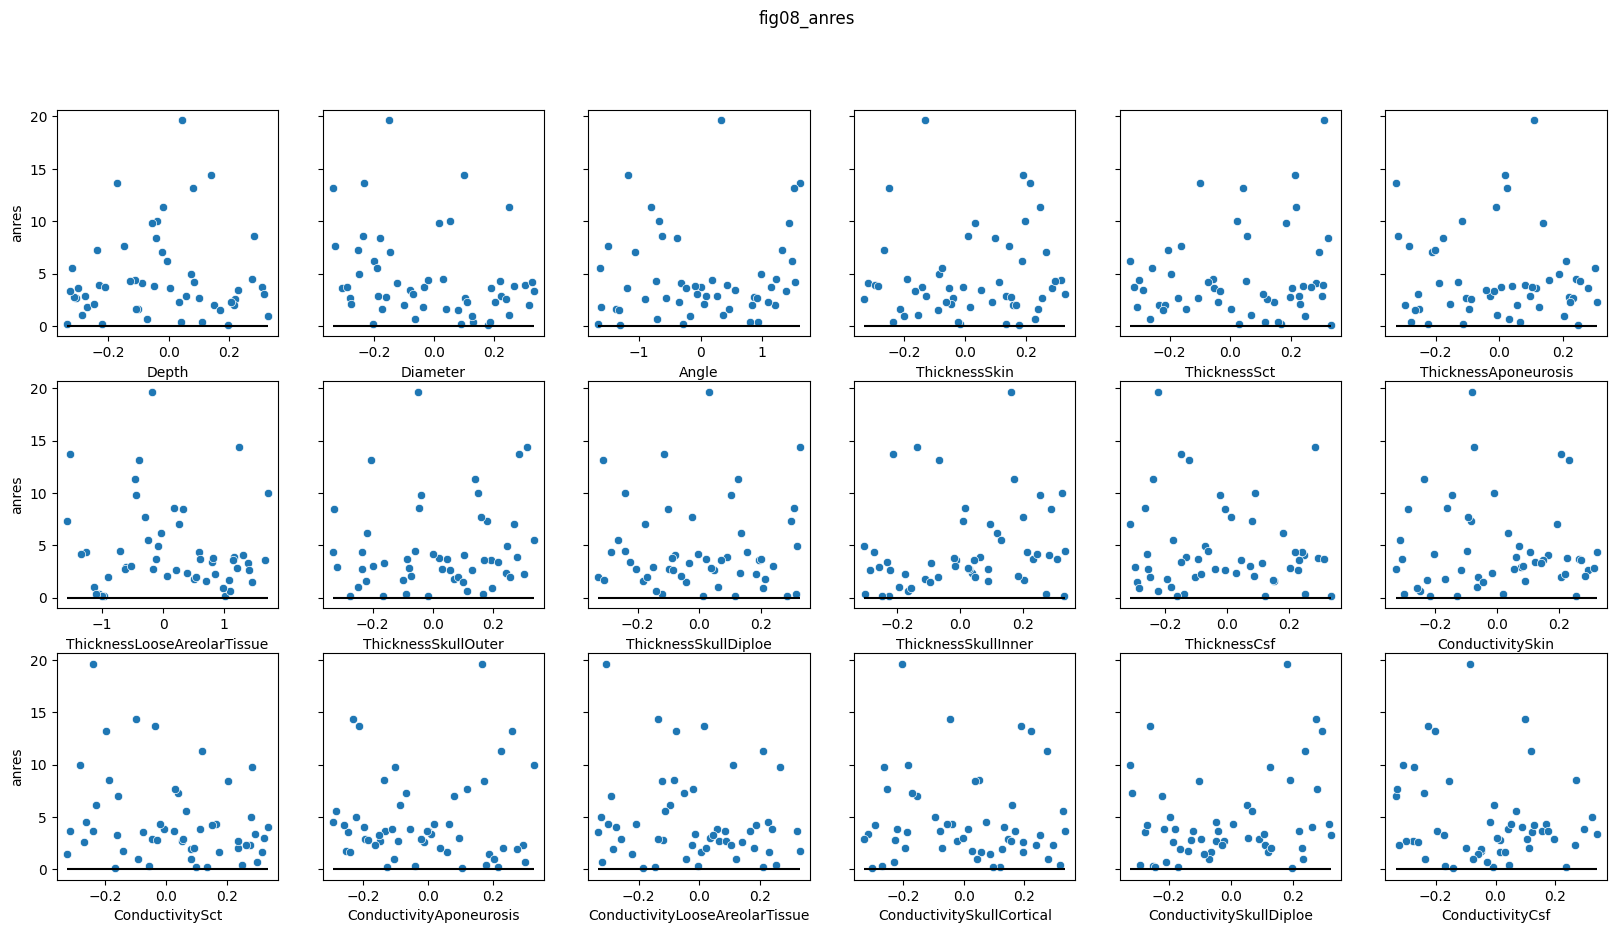

In [ ]:
title = "fig08_anres"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="anres", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

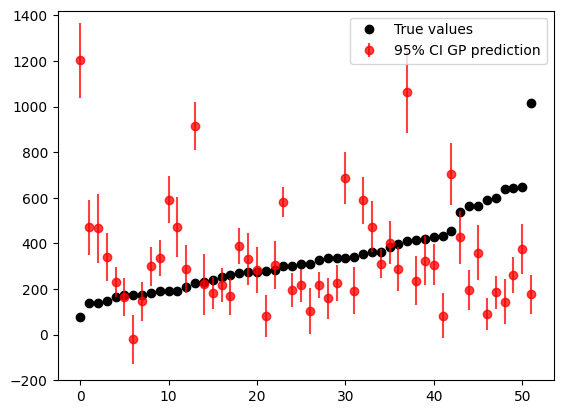

In [ ]:
sorted_idx = np.argsort(y)
y = y[sorted_idx]
y_hat = y_hat[sorted_idx]
std = std[sorted_idx]
plt.plot(y, "ko", label="True values")
plt.errorbar(
    range(len(y_hat)),
    y_hat,
    yerr=2 * std,
    fmt="o",
    color="red",
    alpha=0.75,
    label="95% CI GP prediction",
)
plt.ylim(-200, 1420)
plt.legend()

In [ ]:
np.mean(np.abs(y - y_hat))

np.float64(229.23386895826923)